จากเคสก่อนที่เราจำแนกรูปภาพ 1 รูป 1 Label เคสนี้เราจะจำแนกรูปภาพแบบ 1 รูป หลาย Label โดยใช้ชุดข้อมูลภาพถ่ายจากดาวเทียบ

# 0. Magic Commands


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# 1. Import Library

In [2]:
from fastai import *
from fastai.vision import *
from fastai.metrics import accuracy

# 2. ข้อมูล

เราจะใช้ Data Set จาก Kaggle ซึ่งเป็นเว็บไซต์ที่จัดประกวดแข่งขันทางด้าน Data Science เป็นชุมชนของ Data Scientist ที่ใหญ่ที่สุดในโลก เป็นคนกลางจัดหา Data Set และมี GPU, Notebook ให้ใช้ฟรี ปัจจุบันอยู่ในเครือ Google 

In [3]:
# ! {sys.executable} -m pip install kaggle --upgrade

## สมัคร Kaggle 

1. สมัคร [Kaggle](https://www.kaggle.com)
2. เข้าหน้า My Account
3. ในหมวด API กดปุ่ม <kbd>Create New API Token</kbd>
4. Download ไฟล์ kaggle.json
5. เปิด Jupyter Notebook Dashboard ไปอัพโหลดไฟล์ไว้ใน path ปัจจุบัน
6. Uncomment แล้ว Run โค้ดด้านล่าง เพื่อเก็บไฟล์ Token ไว้ใน ~/.kaggle

In [4]:
# ! mkdir -p ~/.kaggle/
# ! mv kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json

## เข้าร่วมการแข่งขัน

1. เปิดหน้าเว็บการแข่งขัน Kaggle [Planet: Understanding the Amazon from Space Competition](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space)
2. เข้าไปกด Join การแข่งขัน กด Accept กติกา 
3. Uncomment แล้ว Run โค้ดด้านล่างเพื่อ Download ชุดข้อมูล

In [5]:
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  
# ! unzip -q -n {path}/train_v2.csv.zip -d {path}

Install โปรแกรม 7zip สำหรับแตกไฟล์ นามสกุล .7z

In [6]:
# ! conda install --yes --prefix {sys.prefix} -c haasad eidl7zip

แตกไฟล์รูป train-jpg.tar.7z

In [7]:
# ! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path.as_posix()}

## Label อยู่ในไฟล์ csv ##


In [8]:
path = Config.data_path()/'planet'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/home/jupyter/.fastai/data/planet')

ls ดูว่าได้ไฟล์อะไรมาบ้าง เราจะสนใจแค่ไฟล์ train_v2.csv กับโฟลเดอร์ train-jpg

In [9]:
path.ls()

[PosixPath('/home/jupyter/.fastai/data/planet/submission.csv'),
 PosixPath('/home/jupyter/.fastai/data/planet/train_v2.csv'),
 PosixPath('/home/jupyter/.fastai/data/planet/models'),
 PosixPath('/home/jupyter/.fastai/data/planet/train_v2.csv.zip'),
 PosixPath('/home/jupyter/.fastai/data/planet/export.pkl'),
 PosixPath('/home/jupyter/.fastai/data/planet/test-jpg-additional.tar.7z'),
 PosixPath('/home/jupyter/.fastai/data/planet/train-jpg'),
 PosixPath('/home/jupyter/.fastai/data/planet/test-jpg-additional'),
 PosixPath('/home/jupyter/.fastai/data/planet/test-jpg.tar.7z'),
 PosixPath('/home/jupyter/.fastai/data/planet/test-jpg'),
 PosixPath('/home/jupyter/.fastai/data/planet/__MACOSX'),
 PosixPath('/home/jupyter/.fastai/data/planet/train-jpg.tar.7z')]

ในไฟล์ train_v2.csv จะมี ชื่อไฟล์รูป image_name สังเกตว่า tags คือ label บอกหมวดหมู่ รูปหนึ่งรูปอยู่หลายหมวดหมู่ multi-label คั่นด้วย " " (space)

In [10]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


ดึงรายชื่อไฟล์จาก path_images และแสดงรายการ 10 ไฟล์แรก

In [11]:
path_images = path/'train-jpg'
filenames = get_image_files(path_images)
filenames[:10]

[PosixPath('/home/jupyter/.fastai/data/planet/train-jpg/train_1424.jpg'),
 PosixPath('/home/jupyter/.fastai/data/planet/train-jpg/train_27978.jpg'),
 PosixPath('/home/jupyter/.fastai/data/planet/train-jpg/train_24420.jpg'),
 PosixPath('/home/jupyter/.fastai/data/planet/train-jpg/train_887.jpg'),
 PosixPath('/home/jupyter/.fastai/data/planet/train-jpg/train_31571.jpg'),
 PosixPath('/home/jupyter/.fastai/data/planet/train-jpg/train_9438.jpg'),
 PosixPath('/home/jupyter/.fastai/data/planet/train-jpg/train_22505.jpg'),
 PosixPath('/home/jupyter/.fastai/data/planet/train-jpg/train_26308.jpg'),
 PosixPath('/home/jupyter/.fastai/data/planet/train-jpg/train_950.jpg'),
 PosixPath('/home/jupyter/.fastai/data/planet/train-jpg/train_33612.jpg')]

# 3. เตรียมข้อมูล

ข้อมูลรูปถ่ายทางอากาศ เนื่องจากรูปถ่าย ถ่ายจากทางด้านบน Data Augmentation เราสามารถ Flip แนวตั้งได้โดยไม่เสียความหมาย เหมือนรูป หมาแมว ตัวหนังสือ หรือ รูปวิว เราใช้ flip_vert=True 

In [12]:
batchsize = 32
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

สร้าง datasource ด้วย Datablock API ไว้เราจะอธิบายต่อไป

In [13]:
np.random.seed(42)
datasource = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

ใช้รูปขนาดเล็กก่อน จะได้เทรนเร็ว size = 128 x 128 Pixel

In [14]:
imagesize = 128
databunch = (datasource.transform(tfms, size=128)
        .databunch(bs=batchsize).normalize(imagenet_stats))

## สำรวจข้อมูล ##

ลองดูข้อมูล Batch แรก ด้วย show_batch สั่งให้แสดง รูป พร้อม label ในเคสนี้เป็น multi-label คั่นด้วย ; รูปหนึ่งรูปสามารถ จำแนกได้อยู่หลายหมวดพร้อมกัน เช่น เป็น ที่อยู่อาศัย ถนน พื้นที่เพาะปลูก พื้นน้ำ มีเมฆบัง

*เราสามารถรัน cell นี้หลายครั้ง เพื่อเรียกดู batch ต่อ ๆ ไป ได้เรื่อย ๆ เป็นการสำรวจข้อมูล*

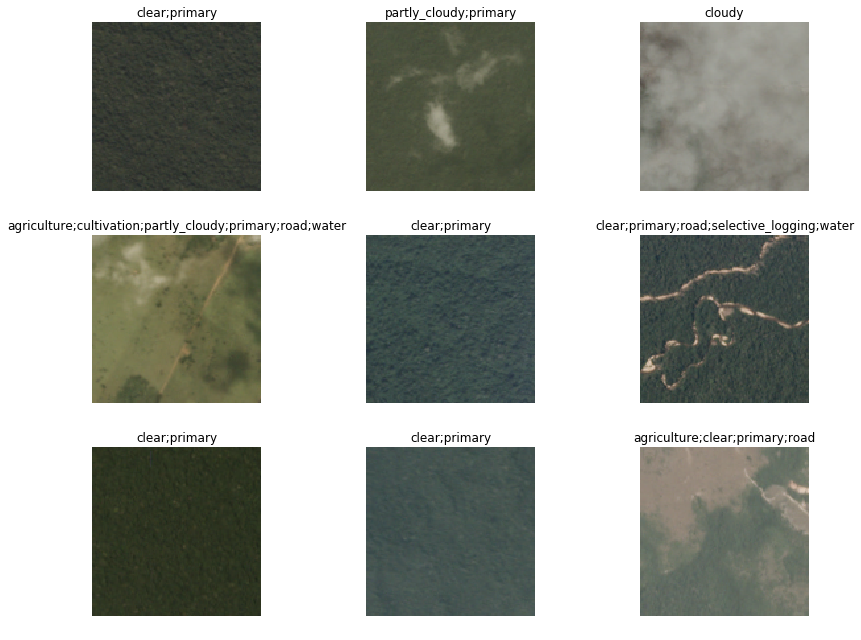

In [15]:
databunch.show_batch(rows=3, figsize=(12,9))

ข้อมูลมี label 17 แบบ และ เราแบ่ง 40,479 ตัวอย่างข้อมูล Split ออก 80/20 เป็น Train Set 32,384 และเป็น Validation Set 8,095

In [16]:
databunch.classes, databunch.c, len(databunch.train_ds), len(databunch.valid_ds)

(['agriculture',
  'artisinal_mine',
  'bare_ground',
  'blooming',
  'blow_down',
  'clear',
  'cloudy',
  'conventional_mine',
  'cultivation',
  'habitation',
  'haze',
  'partly_cloudy',
  'primary',
  'road',
  'selective_logging',
  'slash_burn',
  'water'],
 17,
 32384,
 8095)

# 4. สร้างโมเดล



เนื่องจากเป็น Multi-label ทำให้เราใช้ accuracy ตรง ๆ เหมือนเดิมไม่ได้ 

และกติการการแข่งขัน กำหนดให้ใช้คะแนนจาก F-Score โดยใช้ Accuracy Threshold = 0.2

*ไว้เราจะอธิบายเรื่อง F-Score และ Accuracy Threshold ต่อไป ตอนนี้ขอให้ใช้โค้ดตามด้านล่างไปก่อน*

In [17]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)

สร้าง Learner 

* โดยใส่ metrics เป็น acc_02 และ f_score ที่เราประกาศด้านบน
* callback_fns=ShowGraph คือ ให้โชว์กราฟในทุก Mini-Batch โดยใช้กลไก Callback ที่เราจะอธิบายต่อไป
* learner.to_fp16 คือ ปรับโมเดลไปใช้ Floating Point 16 bit แทน 32 bit เรียกว่า Mixed precision training ไว้เราจะอธิบายต่อไป

In [18]:
learner = cnn_learner(databunch, models.resnet50, 
                      metrics=[acc_02, f_score], 
                      callback_fns=ShowGraph).to_fp16()

# 5. เริ่มต้นเทรนโมเดล

เทรนด้วยค่า Default ไป 8 Epoch

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.135598,0.118911,0.938357,0.895301,01:29
1,0.119625,0.102361,0.949460,0.912360,01:24
2,0.113913,0.096350,0.953217,0.917981,01:24
3,0.105878,0.092997,0.954925,0.920045,01:24
4,0.100429,0.091686,0.955274,0.920789,01:24
5,0.096897,0.089366,0.954802,0.921807,01:25
6,0.095667,0.088940,0.957192,0.923401,01:24
7,0.094524,0.088682,0.957418,0.924154,01:24


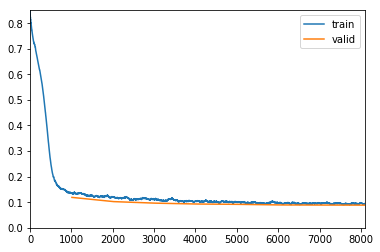

In [19]:
learner.fit_one_cycle(8)

เรามา Save Model ที่เราเพิ่งเทรนไปเก็บไว้ก่อน

In [20]:
learner.save('03a-resnet50-1')

โหลดโมเดลที่เรา Save ไว้ ขึ้นมาใหม่ เตรียมเทรนในขึ้นตอนถัดไป (ที่คอมเม้นท์ไว้ เพราะถ้าไม่ได้เปลี่ยนอะไรก็จะได้ไม่ต้องรัน)

In [21]:
# learner.load('03a-resnet50-1')

# 6. เทรนต่อ

unfreeze layer ทุก Layer ให้สามารถเทรนได้ แล้วเทรนต่อทั้งโมเดล

In [22]:
learner.unfreeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.094739,0.088821,0.957033,0.923011,02:04
1,0.094728,0.089184,0.956182,0.924107,02:03
2,0.092234,0.086315,0.957948,0.925605,02:03
3,0.087997,0.086279,0.958260,0.926645,02:03
4,0.083038,0.085820,0.958726,0.926903,02:03
5,0.083995,0.085577,0.959518,0.927498,02:03


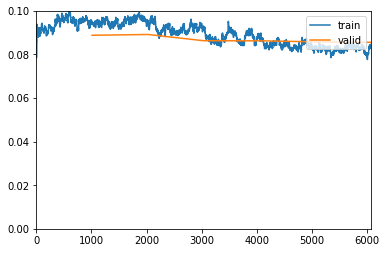

In [23]:
learner.fit_one_cycle(6, max_lr=slice(3e-6,3e-4))

In [24]:
learner.save('03a-resnet50-2')

In [25]:
# learner.load('03a-resnet50-2')

# 7. เทรนต่อ 2

Transfer Learning ด้วยโมเดลของเราเอง ที่เพิ่งเทรนเสร็จ นำมาเทรนต่อด้วย 

1. Data ทีรูปใหญ่ขึ้น เป็น 256 x 256 Pixel
2. normalize ด้วยข้อมูลใน Data Set ตัวเองแทนที่จะเป็น imagenet_stats ไว้เราจะอธิบายในเรื่อง Normalization ต่อไป


In [26]:
imagesize = 256
databunch = (datasource.transform(tfms, size=imagesize)
        .databunch(bs=batchsize).normalize())

learner.data = databunch
databunch.train_ds[0][0].shape

torch.Size([3, 256, 256])

Freeze ใหม่ เพื่อเทรนเฉพาะ Layer สุดท้าย

In [27]:
learner.to_fp16().freeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.093702,0.088736,0.955245,0.924130,03:11
1,0.092924,0.085309,0.957396,0.926427,03:08
2,0.088564,0.085634,0.957250,0.925537,03:07
3,0.081446,0.084912,0.959924,0.928249,03:06
4,0.081398,0.084144,0.959307,0.927837,03:06


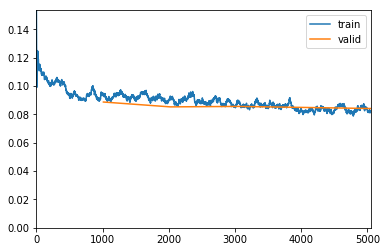

In [28]:
learner.fit_one_cycle(5)

In [29]:
learner.save('03a-resnet50-256-1')

In [30]:
# learner.load('03a-resnet50-256-1')

unfreeze layer ทุก Layer ให้สามารถเทรนได้ แล้วเทรนต่อทั้งโมเดล

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.084223,0.085592,0.959489,0.927793,04:19
1,0.089675,0.083281,0.958536,0.929215,04:18
2,0.085783,0.083162,0.959380,0.929235,04:19
3,0.081307,0.083309,0.960629,0.929317,04:19
4,0.076513,0.082703,0.960615,0.929717,04:19


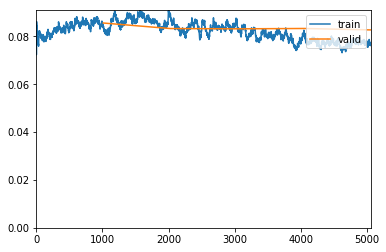

In [31]:
learner.unfreeze()
learner.fit_one_cycle(5, slice(3e-6, 3e-4))

## สำเร็จแล้ว ##

เราใช้เวลาในการเทรนไปเกือบ 60 นาที ได้ F-Score 0.929717

เข้าไปดูใน Kaggle Leaderboard เปรียบเทียบกับ อันดับ 77 จาก ทั้งหมด 938 ทีม หรืออยู่ใน Top 10%


| อันดับ | ชื่อทีม        | F-Score | วันที่ส่ง |
|------|-------------|---------|-------|
| 75   | Jun Shi     | 0.92973 | 2y    |
| 76   | AndrewLamb  | 0.92972 | 2y    |
| 77   | FelixDorrek | 0.92971 | 2y    |
| 78   | MewMewMew   | 0.92966 | 2y    |
| 79   | Dan B       | 0.92962 | 2y    |

*หมายเหตุ คะแนนในเว็บ Kaggle เกิดจากการเทสกับอีกชุดข้อมูล เรียกว่า Test Set ซึ่งจะถูกแบ่งออกมาแต่แรก ไม่มีใครเห็นเพื่อความแฟร์ ดังนั้นคะแนนของเราเวลา Submit จริง ๆ อาจจะแตกต่างไป (อ่านเพิ่มเติมได้ที่ [Train / Test Split คืออะไร](https://www.bualabs.com/archives/532/what-is-train-test-split-why-split-train-set-validation-set-test-set/))*

เรามา Save Model ที่เราเพิ่งเทรนไปเก็บไว้ก่อน

In [32]:
learner.save('03a-resnet50-256-2')

In [33]:
# learner.load('03a-resnet50-256-2')

In [34]:
learner.export()

# 7. ดูผลลัพธ์

In [35]:
interpretation = ClassificationInterpretation.from_learner(learner)

## โมเดลจำแนกได้ถูกต้องเป็นส่วนใหญ่

learner.show_results แสดงผลลัพธ์โดยรวม

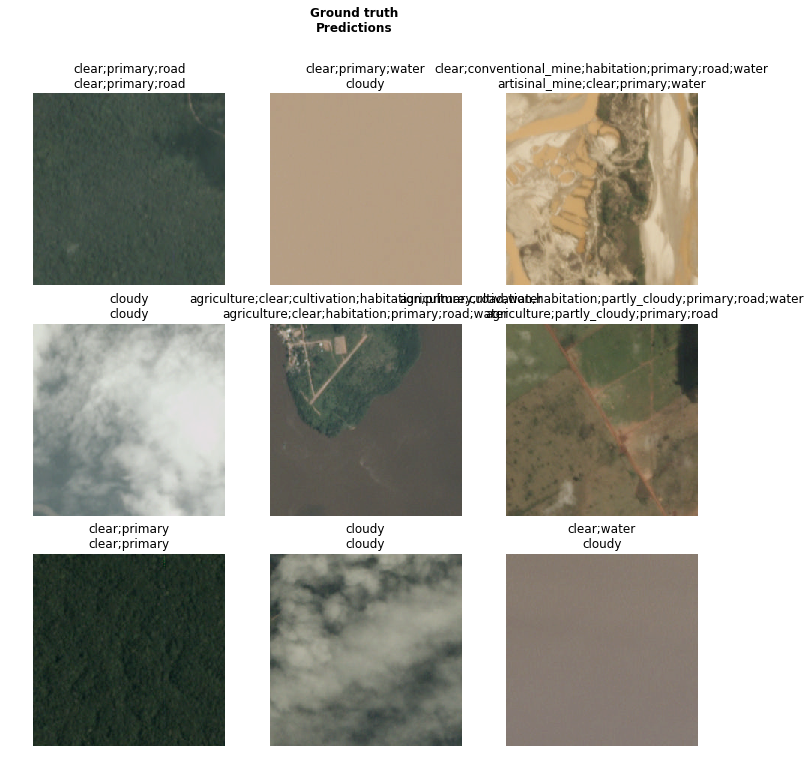

In [36]:
learner.show_results(rows=3)

## โมเดลจำแนก ผิดหมวด

สั่งให้ plot_multi_top_losses คือ แสดง record ที่ ค่า loss มากที่สุด หรือพูดง่าย ๆ ว่าทายถูกแต่ไม่มั่นใจ หรือทายผิดแต่ดันมั่นใจ มากที่สุด 5 อันดับแรก

*ใช้ plot_multi_top_losses แทน plot_top_losses เนื่องจาก multi-label*

149 misclassified samples over 8095 samples in the validation set.


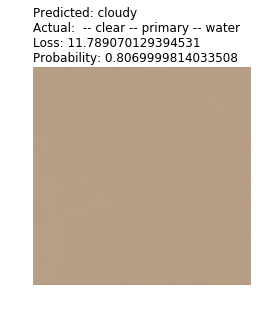

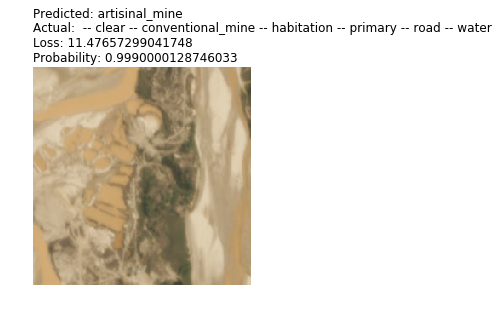

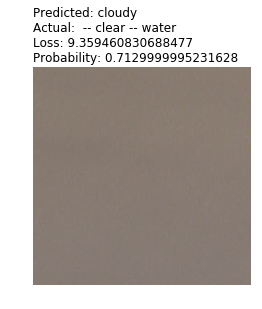

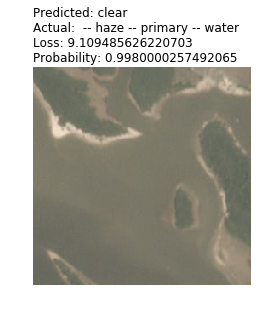

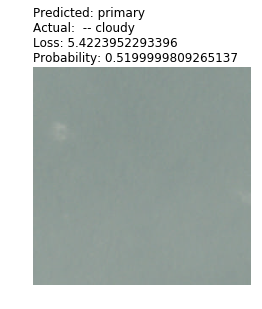

In [37]:
interpretation.plot_multi_top_losses(5, figsize=(4,4))

โมเดลทายผิด 149 จากทั้งหมด 8095 ตัวอย่างข้อมูล ใน Validation Set

# 8. ส่งประกวด

ลองส่งประกวดว่าโมเดลของเราจะทำได้ดีแค่ไหน เทียบกับของคนอื่น ๆ โดย Download ข้อมูล Test Set มา ทำนายแล้ว Submit ส่งไปให้ Kaggle ตรวจ

Uncomment โค้ดด้านล่างแล้ว Run ได้เลย

In [45]:
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z -p {path}  
# ! 7za -bd -y -so x {path}/test-jpg.tar.7z | tar xf - -C {path}
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg-additional.tar.7z -p {path}  
# ! 7za -bd -y -so x {path}/test-jpg-additional.tar.7z | tar xf - -C {path}

test-jpg.tar.7z: Skipping, found more recently modified local copy (use --force to force download)
test-jpg-additional.tar.7z: Skipping, found more recently modified local copy (use --force to force download)


In [46]:
# test = ImageList.from_folder(path/'test-jpg').add(ImageList.from_folder(path/'test-jpg-additional'))
# len(test)

61191

In [47]:
# learner = load_learner(path, test=test)
# preds, _ = learner.to_fp16().get_preds(ds_type=DatasetType.Test)

In [48]:
# thresh = 0.2
# labelled_preds = [' '.join([learner.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [49]:
# labelled_preds[:5]

['clear cloudy primary',
 'cloudy',
 'clear primary',
 'clear habitation primary road water',
 'clear primary']

In [50]:
# fnames = [f.name[:-4] for f in learner.data.test_ds.items]
# df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])
# df.to_csv(path/'submission.csv', index=False)

In [51]:
# ! kaggle competitions submit planet-understanding-the-amazon-from-space -f {path/'submission.csv'} -m "My submission"

100%|███████████████████████████████████████| 2.17M/2.17M [00:02<00:00, 831kB/s]
Successfully submitted to Planet: Understanding the Amazon from Space

## อันดับบน Leaderboard

แล้วเราไปเปิดเว็บ หน้า Leader Board ดูผลคะแนนของเรา เมื่อทดสอบกับ Test Set

| Name           | Submitted    | Wait time | Execution time | Score   |
|----------------|--------------|-----------|----------------|---------|
| submission.csv | 14 hours ago | 0 seconds | 1 seconds      | 0.92897 |

เทียบกับคนอื่น จะเห็นว่าหลุดจาก อันดับ 77 หรือ Top 10% ไปอยู่ประมาณอันดับที่ 100

| อันดับ | ชื่อทีม                  | F-Score | วันที่ส่ง |
|------|-----------------------|---------|-------|
| 98   | works like Brain Stem | 0.92901 | 2y    |
| 99   | Igor Praznik          | 0.92899 | 2y    |
| 100  | kab695                | 0.92895 | 2y    |
| 101  | Zihan Jiang           | 0.92894 | 2y    |
| 102  | XipengLin             | 0.92894 | 2y    |

# 9. สรุป


1. เราสามารถสร้าง Multi-label Image Classification ได้ง่าย ๆ ด้วยชุดข้อมูลรูปภาพ, โค้ดไม่กี่บรรทัด และ GPU ไม่ถึงชั่วโมง
2. เมื่อโมเดลทำอะไรได้มากขึ้น การเทรนโมเดล การวัดผล ก็เริ่มมีความซับซ้อนมากขึ้น ทำให้ใช้เวลา และทรัพยากรในการเทรนมากขึ้น
3. Kaggle เป็นชุมชน และแหล่งความรู้ชั้นดี สำหรับผู้ที่สนใจ Data Science ไม่ว่าจะระดับเริ่มต้น หรือ Advance
4. งานทางด้าน Vision มีอีกหลากหลาย ต่อยอดขึ้นไปอีกได้เรื่อย ๆ เช่น เคสก่อนคือ 1 รูป 1 label, เคสนี้คือ 1 รูป หลาย label, ต่อไปคือ 1 Pixel 1 label, ..., ไปจนถึง ผสมกับ NLP ใช้ภาษามาอธิบายสิ่งที่อยู่บนภาพ ตอบคำถามซับซ้อนได้

# Credit 

* [FastAI: Practical Deep Learning for Coders, v3 - Lesson 3](https://course.fast.ai/videos/?lesson=3)
* [Planet: Understanding the Amazon from Space](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/)